In [3]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
sys.path.append(r'C:\Users\10768\personal files\waiting_time\waiting_time_project')

from utils.logger import logger
from data_process import get_apptointment_info, get_treat_info, fill_nan, get_list
from wtp.duration.predict_lgb_model import FEATURE_NUM, FEATURE_CATE

import warnings
warnings.filterwarnings("ignore")

# 1 Process Data

In [7]:
processed_appointment_data_ = get_apptointment_info()
processed_treatment_data_ = get_treat_info()

processed_appointment_data = processed_appointment_data_.copy()
processed_treatment_data = processed_treatment_data_.copy()

WAITING TIME: 2020-08-18 11:04:27 [INFO] Get information about appointment!
WAITING TIME: 2020-08-18 11:04:27 [DEBUG] Get table of appointment!
WAITING TIME: 2020-08-18 11:05:10 [DEBUG] Get table of patient!
WAITING TIME: 2020-08-18 11:05:11 [DEBUG] Merge appointment and patient!
WAITING TIME: 2020-08-18 11:05:12 [DEBUG] Get table of patientdoctor!
WAITING TIME: 2020-08-18 11:05:14 [DEBUG] Merge patientdoctor!
WAITING TIME: 2020-08-18 11:05:14 [DEBUG] Get table of diagnosis!
WAITING TIME: 2020-08-18 11:05:15 [DEBUG] Get table of diagnosis!
WAITING TIME: 2020-08-18 11:05:15 [DEBUG] Merge diagnosis and diagnosistranslation!
WAITING TIME: 2020-08-18 11:05:16 [DEBUG] Get table of course!
WAITING TIME: 2020-08-18 11:05:17 [DEBUG] Get table of plan!
WAITING TIME: 2020-08-18 11:05:21 [DEBUG] Merge plan and course!
WAITING TIME: 2020-08-18 11:05:22 [DEBUG] Merge plan_course and appointment!
WAITING TIME: 2020-08-18 11:05:22 [DEBUG] Drop columns with same values!
WAITING TIME: 2020-08-18 11:05:

In [10]:
processed_data = pd.merge(processed_appointment_data, processed_treatment_data, on=['PatientSerNum', 'date'], how='inner')
processed_data = processed_data.sort_values(
    by=['PatientSerNum', 'AppointmentSerNum', 'ScheduledStartTime', 'FractionNumber']).reset_index(drop=True)

In [12]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(processed_data[FEATURE_NUM])
processed_data.loc[:, FEATURE_NUM] = imp_mean.transform(processed_data[FEATURE_NUM])

In [13]:
cate_features = processed_data[FEATURE_CATE].select_dtypes(include=['category', 'object']).columns
cate_features_number = [i for i in FEATURE_CATE if i not in cate_features]

processed_data.loc[:, cate_features] = processed_data.loc[:, cate_features].fillna('NULL').reset_index(drop=True)
processed_data.loc[:, cate_features_number] = processed_data.loc[:, cate_features_number].fillna(0).reset_index(drop=True)

# imp_mean = SimpleImputer(strategy='most_frequent')
# imp_mean.fit(processed_data[FEATURE_CATE])
# processed_data.loc[:, FEATURE_CATE] = imp_mean.transform(processed_data[FEATURE_CATE])

In [14]:
for col in processed_data.columns:
    if col in FEATURE_CATE:
        processed_data[col] = processed_data[col].astype('category').reset_index(drop=True)
    if col in FEATURE_NUM:
        processed_data[col] = processed_data[col].astype('float').reset_index(drop=True)

In [ ]:
print('Count Appointment with multiple rows')
processed_data_grouped = processed_data.groupby('AppointmentSerNum')
count_appt = processed_data_grouped.count()
appt_one_list = count_appt[count_appt.Sex == 1].index.tolist()
appt_more_list = count_appt[count_appt.Sex > 1].index.tolist()
print(f'{len(appt_one_list)} with one appointment')
print(f'{len(appt_more_list)} with more appointment')

## One-hot encoding

In [ ]:
# 数字也能够正常处理，比如出现0，同样会正常处理，并不会认为0 是没有值
def one_hot_enc(feature, data):
    one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    one_hot_encoder.fit(data[[feature]])
    return one_hot_encoder

In [15]:
label_encoder_dxt_AliasName = one_hot_enc('dxt_AliasName', processed_data)
label_encoder_Sex = one_hot_enc('Sex', processed_data)
label_encoder_AliasSerNum = one_hot_enc('AliasSerNum', processed_data)
label_encoder_month = one_hot_enc('month', processed_data)
label_encoder_week = one_hot_enc('week', processed_data)
label_encoder_hour = one_hot_enc('hour', processed_data)
label_encoder_DoctorSerNum = one_hot_enc('DoctorSerNum', processed_data)
label_encoder_TreatmentOrientation = one_hot_enc('TreatmentOrientation', processed_data)
label_encoder_FractionNumber = one_hot_enc('FractionNumber', processed_data)
label_encoder_UserName = one_hot_enc('UserName', processed_data)
label_encoder_CourseId = one_hot_enc('CourseId', processed_data)
label_encoder_ResourceSerNum = one_hot_enc('ResourceSerNum', processed_data)

## Combine multiple values in one-appointment

In [ ]:
def combine_mul_row_appt(data_part1):
    new_appt = pd.DataFrame({})

    print('Start cateorical features')
    print('\nStart PatientSerNum')
    new_appt['PatientSerNum'] = data_part1.groupby('AppointmentSerNum').PatientSerNum.apply(set)
    new_appt['PatientSerNum'] = new_appt['PatientSerNum'].apply(lambda x: get_list(x))

    print('Start Sex')
    new_appt['Sex'] = data_part1.groupby('AppointmentSerNum').Sex.apply(set)
    new_appt['Sex'] = new_appt['Sex'].apply(lambda x: get_list(x))

    print('Start DoctorSerNum')
    new_appt['DoctorSerNum'] = data_part1.groupby('AppointmentSerNum').DoctorSerNum.apply(set)
    new_appt['DoctorSerNum'] = new_appt['DoctorSerNum'].apply(lambda x: get_list(x))

    print('Start date')
    new_appt['date'] = data_part1.groupby('AppointmentSerNum').date.apply(set)
    new_appt['date'] = new_appt['date'].apply(lambda x: get_list(x))

    print('Start ScheduledStartTime')
    new_appt['ScheduledStartTime'] = data_part1.groupby('AppointmentSerNum').ScheduledStartTime.apply(set)
    new_appt['ScheduledStartTime'] = new_appt['ScheduledStartTime'].apply(lambda x: get_list(x))

    print('Start ScheduledEndTime')
    new_appt['ScheduledEndTime'] = data_part1.groupby('AppointmentSerNum').ScheduledEndTime.apply(set)
    new_appt['ScheduledEndTime'] = new_appt['ScheduledEndTime'].apply(lambda x: get_list(x))

    print('Start ActualStartDate')
    new_appt['ActualStartDate'] = data_part1.groupby('AppointmentSerNum').ActualStartDate.apply(set)
    new_appt['ActualStartDate'] = new_appt['ActualStartDate'].apply(lambda x: get_list(x))

    print('Start ActualEndDate')
    new_appt['ActualEndDate'] = data_part1.groupby('AppointmentSerNum').ActualEndDate.apply(set)
    new_appt['ActualEndDate'] = new_appt['ActualEndDate'].apply(lambda x: get_list(x))

    print('Start dxt_AliasName')
    new_appt['dxt_AliasName'] = data_part1.groupby('AppointmentSerNum').dxt_AliasName.apply(set)
    new_appt['dxt_AliasName'] = new_appt['dxt_AliasName'].apply(lambda x: get_list(x))

    print('Start AliasSerNum')
    new_appt['AliasSerNum'] = data_part1.groupby('AppointmentSerNum').AliasSerNum.apply(set)
    new_appt['AliasSerNum'] = new_appt['AliasSerNum'].apply(lambda x: get_list(x))

    print('Start CourseSerNum')
    new_appt['CourseSerNum'] = data_part1.groupby('AppointmentSerNum').CourseSerNum.apply(set)
    new_appt['CourseSerNum'] = new_appt['CourseSerNum'].apply(lambda x: get_list(x))

    print('Start PlanSerNum')
    new_appt['PlanSerNum'] = data_part1.groupby('AppointmentSerNum').PlanSerNum.apply(set)
    new_appt['PlanSerNum'] = new_appt['PlanSerNum'].apply(lambda x: get_list(x))

    print('Start TreatmentOrientation')
    new_appt['TreatmentOrientation'] = data_part1.groupby('AppointmentSerNum').TreatmentOrientation.apply(set)
    new_appt['TreatmentOrientation'] = new_appt['TreatmentOrientation'].apply(lambda x: get_list(x))

    print('Start month')
    new_appt['month'] = data_part1.groupby('AppointmentSerNum').month.apply(set)
    new_appt['month'] = new_appt['month'].apply(lambda x: get_list(x))

    print('Start week')
    new_appt['week'] = data_part1.groupby('AppointmentSerNum').week.apply(set)
    new_appt['week'] = new_appt['week'].apply(lambda x: get_list(x))

    print('Start hour')
    new_appt['hour'] = data_part1.groupby('AppointmentSerNum').hour.apply(set)
    new_appt['hour'] = new_appt['hour'].apply(lambda x: get_list(x))

    print('Start AppointmentSerNum')
    new_appt['AppointmentSerNum'] = new_appt.index.tolist()


    print('Start numberical features')
    print('\nStart age')
    new_appt['age'] = data_part1.groupby('AppointmentSerNum').age.mean()

    print('Start Scheduled_duration')
    new_appt['Scheduled_duration'] = data_part1.groupby('AppointmentSerNum').Scheduled_duration.mean()

    print('Start Actual_duration')
    new_appt['Actual_duration'] = data_part1.groupby('AppointmentSerNum').Actual_duration.mean()
    
    new_appt.reset_index(drop = True, inplace = True)
    
    return new_appt

In [ ]:
def combine_mul_row_treat(data_part2):
    new_treat = pd.DataFrame({})

    print('Start categorical features')
    print('\nStart FractionNumber')
    new_treat['FractionNumber'] = data_part2.groupby(['PatientSerNum', 'date']).FractionNumber.apply(set)
    new_treat['FractionNumber'] = new_treat['FractionNumber'].apply(lambda x: get_list(x))

    print('Start UserName')
    new_treat['UserName'] = data_part2.groupby(['PatientSerNum', 'date']).UserName.apply(set)
    new_treat['UserName'] = new_treat['UserName'].apply(lambda x: get_list(x))

    print('Start RadiationSerNum')
    new_treat['RadiationSerNum'] = data_part2.groupby(['PatientSerNum', 'date']).RadiationSerNum.apply(set)
    new_treat['RadiationSerNum'] = new_treat['RadiationSerNum'].apply(lambda x: get_list(x))

    print('Start ResourceSerNum')
    new_treat['ResourceSerNum'] = data_part2.groupby(['PatientSerNum', 'date']).ResourceSerNum.apply(set)
    new_treat['ResourceSerNum'] = new_treat['ResourceSerNum'].apply(lambda x: get_list(x))

    print('Start CourseId')
    new_treat['CourseId'] = data_part2.groupby(['PatientSerNum', 'date']).CourseId.apply(set)
    new_treat['CourseId'] = new_treat['CourseId'].apply(lambda x: get_list(x))

    print('Start PatientSerNum')
    new_treat['PatientSerNum'] = new_treat.index.get_level_values(level = 0).tolist()

    print('Start date')
    new_treat['date'] = new_treat.index.get_level_values(level = 1).tolist()
    
    
    print('Start numberical features')
    print('\nStart ImagesTaken_total')
    new_treat['ImagesTaken_total'] = data_part2.groupby(['PatientSerNum', 'date']).ImagesTaken.sum()

    print('Start MU_total')
    new_treat['MU_total'] = data_part2.groupby(['PatientSerNum', 'date']).MU.sum()

    print('Start MUCoeff_total')
    new_treat['MUCoeff_total'] = data_part2.groupby(['PatientSerNum', 'date']).MUCoeff.sum()

    print('Start TreatmentTime_total')
    new_treat['TreatmentTime_total'] = data_part2.groupby(['PatientSerNum', 'date']).TreatmentTime.sum()
    
    new_treat.reset_index(drop = True, inplace = True)
    
    return new_treat

In [17]:
# 将相同的AppointmentSerNum 的信息进行合并
print('='*40)
print('Combine Appointment with multiple rows')
new_appt = combine_mul_row_appt(processed_data)
print(f'The shape of new_appt is {new_appt.shape}')
new_treat = combine_mul_row_treat(processed_data)
print(f'The shape of new_treat is {new_treat.shape}')

Combine Appointment with multiple rows
Start cateorical features

Start PatientSerNum
Start Sex
Start DoctorSerNum
Start date
Start ScheduledStartTime
Start ScheduledEndTime
Start ActualStartDate
Start ActualEndDate
Start dxt_AliasName
Start AliasSerNum
Start CourseSerNum
Start PlanSerNum
Start TreatmentOrientation
Start month
Start week
Start hour
Start AppointmentSerNum
Start numberical features

Start age
Start Scheduled_duration
Start Actual_duration
The shape of new_appt is (139944, 20)
Start categorical features

Start FractionNumber
Start UserName
Start RadiationSerNum
Start ResourceSerNum
Start CourseId
Start PatientSerNum
Start date
Start numberical features

Start ImagesTaken_total
Start MU_total
Start MUCoeff_total
Start TreatmentTime_total
The shape of new_treat is (139277, 11)


In [18]:
# 将appt 和treat 信息进行合并，得到DATA
print('='*40)
print('Merge data_appt and data_treat')
DATA = pd.merge(new_appt, new_treat, on = ['PatientSerNum', 'date'], how = 'inner')
DATA = DATA.sort_values(by = ['PatientSerNum', 'AppointmentSerNum', 'ScheduledStartTime']).reset_index(drop=True)
print(f'The shape of data is {DATA.shape}')

Merge data_appt and data_treat
The shape of data is (139944, 29)


## Filter samples

In [19]:
# 筛选后的DATA
print('='*40)
print('Filter data')
DATA_ = DATA[(DATA.Actual_duration >= 10) & (DATA.Actual_duration <= 60)].reset_index(drop=True)
print(f'The shape of data is {DATA_.shape}')

Filter data
The shape of data is (126936, 29)


In [20]:
NN_NUM_FEATURES = ['Scheduled_duration', 'Actual_duration',
                   'age', 'TreatmentTime_total', 'ImagesTaken_total',
                   'MU_total', 'MUCoeff_total', 'Interval_scheduled']

# RadiationId
NN_CATE_FEATURES = ['dxt_AliasName', 'Sex', 'AliasSerNum',
                    'month', 'week', 'hour', 'DoctorSerNum', 
                    'TreatmentOrientation', 'FractionNumber',
                    'UserName', 'CourseId', 'ResourceSerNum']

In [21]:
# 只保留存在一个以上Appointment 的患者
print('='*40)
print('Select Patient with one more Appointment')
DATA_grouped = DATA_.groupby('PatientSerNum')
series_count = DATA_grouped.count()
series_seq = series_count[series_count.AppointmentSerNum > 1].index.tolist()
series_one = series_count[series_count.AppointmentSerNum == 1].index.tolist()
print(f'series_seq {len(series_seq)}')
print(f'series_one {len(series_one)}')
series_seq = pd.DataFrame({'PatientSerNum': series_seq})
series_data = pd.merge(series_seq, DATA, on = 'PatientSerNum', how = 'inner')
series_data.sort_values(by = ['PatientSerNum', 'ScheduledStartTime'], inplace = True)


# 符合条件的患者的序列，全部课用样本
series_data_grouped = series_data.groupby('PatientSerNum')
pat_list = shuffle(list(series_data_grouped.groups.keys()), random_state = 1)
print(f'The total number of patient is {len(pat_list)}')


# 因为使用非固定长度的样本进行训练，因此 APPT_LEN没有用
# FEATURE_LEN 是根据编码后的结果到的
# 后面的编码由于存在，一个样本中多个值的情况，因此一次一个样本进行one hot 的转化（没想出更好的办法解决这一问题）
APPT_LEN = series_data_grouped.count().AppointmentSerNum.max()
FEATURE_LEN = 441
print(f'The max length of patient is {APPT_LEN}')
print(f'The number of input encoded-feature is {FEATURE_LEN}')

Select Patient with one more Appointment
series_seq 8101
series_one 862
The total number of patient is 8101
The max length of patient is 80
The number of input encoded-feature is 441


# 2 Generate Samples and Train

In [27]:
def generate_sample(train_sample_):
    train_sample = train_sample_.reset_index(drop=True)

    # 样本标签
    train_y = np.array([train_sample.Actual_duration.iloc[-1]])
    
    # 最后一个appointment 为我们需要预测的真实治疗时长所对应的appointment，所以需要设置为0
    train_sample.Actual_duration.iloc[-1] = 0

    # 因为存在相隔很远的两次预约，因此，构造特征Interval_scheduled 来度量两次预约之间的距离
    # 上一次的预期治疗开始时间
    train_sample['Last_ScheduledStartTime'] = train_sample.ScheduledStartTime.shift(
        periods = 1, fill_value = train_sample.ScheduledStartTime.iloc[0])
    train_sample['Interval_scheduled'] = train_sample.apply(
        lambda x: (x.ScheduledStartTime - x.Last_ScheduledStartTime).days, axis = 1)
    
    # 对分类变量进行one-hot encoding处理
    encode_cate = pd.DataFrame({})
    
    # 这个地方将Sex 作为序列的一部分，并不是在最后的隐藏层进行合并
    encode_cate['Sex'] = train_sample['Sex'].apply(
        lambda x: sum(label_encoder_Sex.transform(np.array(x).reshape(-1,1))))
    train_x = np.vstack(encode_cate.Sex.tolist())
    
    encode_cate['dxt_AliasName'] = train_sample['dxt_AliasName'].apply(
        lambda x: sum(label_encoder_dxt_AliasName.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.dxt_AliasName.tolist())))

    train_sample['AliasSerNum'] = train_sample['AliasSerNum'].astype(str)
    encode_cate['AliasSerNum'] = train_sample['AliasSerNum'].apply(
        lambda x: sum(label_encoder_AliasSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.AliasSerNum.tolist())))

    encode_cate['month'] = train_sample['month'].apply(
        lambda x: sum(label_encoder_month.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.month.tolist())))

    encode_cate['week'] = train_sample['week'].apply(
        lambda x: sum(label_encoder_week.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.week.tolist())))

    encode_cate['hour'] = train_sample['hour'].apply(
        lambda x: sum(label_encoder_hour.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.hour.tolist())))

    encode_cate['DoctorSerNum'] = train_sample['DoctorSerNum'].apply(
        lambda x: sum(label_encoder_DoctorSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.DoctorSerNum.tolist())))

    encode_cate['TreatmentOrientation'] = train_sample['TreatmentOrientation'].apply(
        lambda x: sum(label_encoder_TreatmentOrientation.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.TreatmentOrientation.tolist())))

    encode_cate['FractionNumber'] = train_sample['FractionNumber'].apply(
        lambda x: sum(label_encoder_FractionNumber.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.FractionNumber.tolist())))

    encode_cate['UserName'] = train_sample['UserName'].apply(
        lambda x: sum(label_encoder_UserName.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.UserName.tolist())))

    encode_cate['CourseId'] = train_sample['CourseId'].apply(
        lambda x: sum(label_encoder_CourseId.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.CourseId.tolist())))

    encode_cate['ResourceSerNum'] = train_sample['ResourceSerNum'].apply(
        lambda x: sum(label_encoder_ResourceSerNum.transform(np.array(x).reshape(-1,1))))
    train_x = np.hstack((train_x, np.vstack(encode_cate.ResourceSerNum.tolist())))
    
    # 将数值变量和非数值变量进行合并
    train_num = train_sample[NN_NUM_FEATURES]
    train_x = np.hstack((train_x, train_num))

    train_x[np.isnan(train_x)]=0
    return train_x, train_y

In [35]:
# 不指定时间戳长度
model_sequence = Sequential()
model_sequence.add(
    layers.LSTM(128,
        batch_input_shape = (None , None, 299),
        dropout=0.1,
        recurrent_dropout=0.5
    )
)

# model_sequence.add(layers.LSTM(
#         output_dim = 32,
#         ))
# stateful = True 本次batch的参数返回到下一次的训练中

model_sequence.add(layers.Dense(32))

model_sequence.add(layers.Dense(1))

adam = optimizers.Adam(lr=0.001)
model_sequence.compile(
        optimizer = adam,
        loss = 'mae'
        )

model_sequence.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               219136    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 223,297
Trainable params: 223,297
Non-trainable params: 0
_________________________________________________________________


In [29]:
pat_list = shuffle(pat_list)
train_list = pat_list[: int(0.95*len(pat_list))]
print(f'The number of train_list {len(train_list)}')
# val_list = pat_list[int(0.8*len(pat_list)): int(0.9*len(pat_list))]
# print(f'The number of val_list {len(val_list)}')
test_list = pat_list[int(0.95*len(pat_list)): ]
print(f'The number of test_list {len(test_list)}')

The number of train_list 7695
The number of test_list 406


In [31]:
print('='*40)
print('Start training')
loss_all_list = []
loss_batch_list = []
val_batch_list = []

train_loss_batch = 0
for i in range(len(train_list)):
    # 构造训练数据
    pat = train_list[i]
    train_sample = series_data_grouped.get_group(pat)
    train_x_i, train_y_i = generate_sample(train_sample)
    
    train_x = np.array([train_x_i])
    train_y = np.array([train_y_i])
    
#     print(f"train_x: {train_x_i.shape}")
#     print(f"train_y: {train_y_i.shape}")
    
    train_loss = model_sequence.train_on_batch(train_x, train_y)
    loss_all_list.append(train_loss)
    
    # loss 收敛很快，保存每50批次的loss，画出训练的曲线
    if (i+1)%50 != 0:
        train_loss_batch = train_loss_batch + train_loss
        
    else:
        loss_batch_list.append(train_loss_batch/50)
        print(f'\nBatch {(i+1)/50} train loss {(i+1)/50} {train_loss_batch/50}')
        train_loss_batch = 0
        
        # 全部验证集
        val_list = []
        for j in range(len(test_list)):
            pat = test_list[j]
            train_sample = series_data_grouped.get_group(pat)
            train_x_i, train_y_i = generate_sample(train_sample)
            
            train_x = np.array([train_x_i])
            train_y = np.array([train_y_i])
            val_mae = model_sequence.evaluate(train_x, train_y, verbose=0)
            val_list.append(val_mae)
            
        print(f'\nBatch {(i+1)/50} validation loss {sum(val_list)/len(val_list)}')
        val_batch_list.append(val_list)

Start training

Batch 1.0 train loss 1.0 14.589589576721192

Batch 1.0 validation loss 7.131570637519724

Batch 2.0 train loss 2.0 8.047772035598754

Batch 2.0 validation loss 6.479349749428885

Batch 3.0 train loss 3.0 6.340031099319458

Batch 3.0 validation loss 6.627906146307884

Batch 4.0 train loss 4.0 6.754651889801026

Batch 4.0 validation loss 6.193003788370217

Batch 5.0 train loss 5.0 5.2847356033325195

Batch 5.0 validation loss 6.07071366098714

Batch 6.0 train loss 6.0 4.485616455078125

Batch 6.0 validation loss 6.317784548980262

Batch 7.0 train loss 7.0 5.908207855224609

Batch 7.0 validation loss 6.200028186948429

Batch 8.0 train loss 8.0 6.495274000167846

Batch 8.0 validation loss 6.150089195796421

Batch 9.0 train loss 9.0 5.446436786651612

Batch 9.0 validation loss 5.935462857702095

Batch 10.0 train loss 10.0 7.221195058822632

Batch 10.0 validation loss 5.899503437756318

Batch 11.0 train loss 11.0 6.110713748931885

Batch 11.0 validation loss 5.909816861739887


Batch 90.0 train loss 90.0 5.822280921936035

Batch 90.0 validation loss 5.9394423292188225

Batch 91.0 train loss 91.0 8.0966575050354

Batch 91.0 validation loss 6.069568681012234

Batch 92.0 train loss 92.0 7.692733602523804

Batch 92.0 validation loss 5.980375266427477

Batch 93.0 train loss 93.0 4.594138088226319

Batch 93.0 validation loss 6.100936504420389

Batch 94.0 train loss 94.0 5.621616477966309

Batch 94.0 validation loss 5.84772304008747

Batch 95.0 train loss 95.0 4.782088871002197

Batch 95.0 validation loss 5.924538541897177

Batch 96.0 train loss 96.0 6.88336485862732

Batch 96.0 validation loss 5.838412916719033

Batch 97.0 train loss 97.0 6.415655908584594

Batch 97.0 validation loss 5.823845903274461

Batch 98.0 train loss 98.0 7.185600204467773

Batch 98.0 validation loss 5.93386143886397

Batch 99.0 train loss 99.0 5.4102555274963375

Batch 99.0 validation loss 5.838242436864693

Batch 100.0 train loss 100.0 5.189827318191528

Batch 100.0 validation loss 5.9714

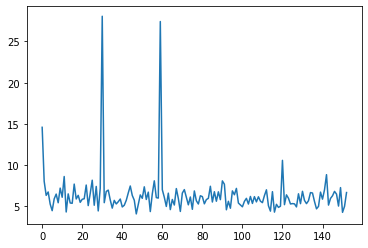

In [32]:
x = range(len(loss_batch_list))
y = loss_batch_list
plt.plot(x, y)
plt.show()